*Ce tutoriel est inspiré du code du module 6 du cours [**AWS Computer Vision: Getting Started with GluonCV**](https://www.coursera.org/learn/aws-computer-vision-gluoncv/home/welcome).\
Je vous recommande ce cours pour aller plus loin dans le **Computer Vision**.*

# Détection d'objets avec GluonCV
Ce tutoriel a pour but de présenter un exemple d'utilisation de **GluonCV** et **MXNet** pour la détection d'objets.\
Durant ce tutoriel, nous ferons :
* du *traitement d'images* ;
* de la *détection d'objets* dans nos images ;
* du *comptage d'objets* dans nos images ;
* et plus spécifiquement, *le comptage de personnes* dans nos images ;

## 0) Définition de l'environnement
Nous allons importer toutes les librairies nécessaires à notre tutoriel.

In [1]:
!pip install mxnet gluoncv

     |████████████████████████████████| 55.0MB 68kB/s 
     |████████████████████████████████| 819kB 46.2MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv as gcv
from pylab import rcParams
import matplotlib.pyplot as plt
from gluoncv import model_zoo, data, utils
import numpy as np
import os
from pathlib import Path

rcParams['figure.figsize'] = 5, 10

## 1) Choix du modèle
La librairie **GluonCV** compte un grand nombre de modèles pour faire de la *classification d'images*, de la *détection d'objets*, de la *segmentation sémantique* et plein d'autres (*voir [ici](https://gluon-cv.mxnet.io/tutorials/index.html) pour les autres applications*).

In [3]:
for model in gcv.model_zoo.get_model_list():
    print(model)

resnet18_v1
resnet34_v1
resnet50_v1
resnet101_v1
resnet152_v1
resnet18_v2
resnet34_v2
resnet50_v2
resnet101_v2
resnet152_v2
resnest14
resnest26
resnest50
resnest101
resnest200
resnest269
se_resnet18_v1
se_resnet34_v1
se_resnet50_v1
se_resnet101_v1
se_resnet152_v1
se_resnet18_v2
se_resnet34_v2
se_resnet50_v2
se_resnet101_v2
se_resnet152_v2
vgg11
vgg13
vgg16
vgg19
vgg11_bn
vgg13_bn
vgg16_bn
vgg19_bn
alexnet
densenet121
densenet161
densenet169
densenet201
squeezenet1.0
squeezenet1.1
googlenet
inceptionv3
xception
xception71
mobilenet1.0
mobilenet0.75
mobilenet0.5
mobilenet0.25
mobilenetv2_1.0
mobilenetv2_0.75
mobilenetv2_0.5
mobilenetv2_0.25
mobilenetv3_large
mobilenetv3_small
mobile_pose_resnet18_v1b
mobile_pose_resnet50_v1b
mobile_pose_mobilenet1.0
mobile_pose_mobilenetv2_1.0
mobile_pose_mobilenetv3_large
mobile_pose_mobilenetv3_small
ssd_300_vgg16_atrous_voc
ssd_300_vgg16_atrous_coco
ssd_300_vgg16_atrous_custom
ssd_512_vgg16_atrous_voc
ssd_512_vgg16_atrous_coco
ssd_512_vgg16_atrous_cus

Dans notre tutoriel, nous voulons compter des personnes présentes dans plusieurs images. Et le modèle le plus adapté est le [*yolo3_darknet53_coco*](https://gluon-cv.mxnet.io/api/model_zoo.html?highlight=yolo3_darknet#gluoncv.model_zoo.yolo3_darknet53_coco).\
En effet, il permet de traiter plus de **100 images par seconde** et il est **moins gourmand en mémoire**.\
*Voir [ici](https://gluon-cv.mxnet.io/model_zoo/detection.html) pour la comparaison des différents modèles de détection d'objets.*

In [4]:
selected_model = 'yolo3_darknet53_coco'

In [5]:
# Define network
network = gcv.model_zoo.get_model(selected_model, pretrained=True)

100%|██████████| 224190/224190 [00:06<00:00, 32344.31KB/s]


## 2) Traitement d'images

### Chargement d'une image

In [6]:
def load_image(filepath):
    """
    Charge une image.

    @parameter
        filepath: chemin de fichier de notre image RGB de format JPG.
            Il est de type string (str)
    
    @return
        imageHWC: un tableau de type mx.nd.NDArray avec des intensités de pixel 
            de la forme HWC (H: Height ; W: Width ; C: Channel)
    """

    imageHWC = image.imread(filepath)

    return imageHWC

In [13]:
# Load image
imageHWC = load_image("./20200704_212108.jpg")

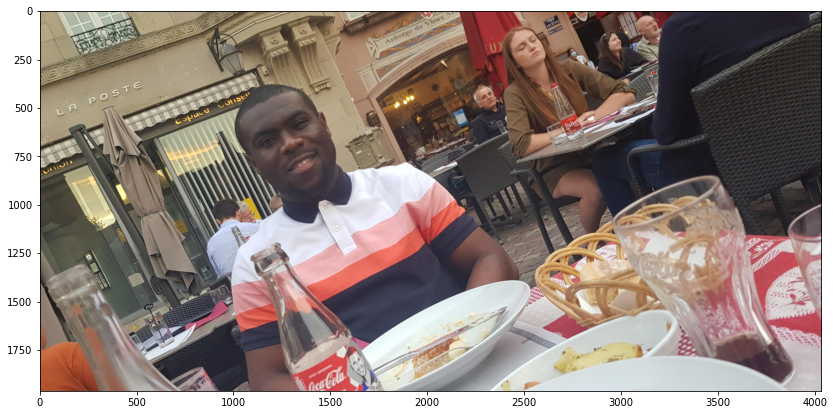

In [14]:
# Plot image
plt.imshow(imageHWC.asnumpy())
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()

### Transformation de l'image

In [10]:
def transform_image(array):
    """
    Transforme une image en :

    1) Redéfinissant la taille de l'image à la plus petite dimension qui est 416.
        Exemple : (832, 3328) -> (416, 1664).
    2) Recadrant à un carré central de dimension (416, 416).
    3) Convertissant l'image de la forme HWC à CHW.
    4) Normalisant l'image en utilisant des statistiques de COCO (normalisation 
        par moyenne et variance du canal couleur).
    5) Créant un batch d'une seule image.

    @parameter
        array: mx.nd.NDArray dans la forme HWC
    
    @return
        Un tuple de (mx.nd.NDArray, numpy.ndarray).
            Ce tuple est un batch d'une image transformée (dans la forme NCHW) 
                et une image non-normalisée.
    """

    return data.transforms.presets.yolo.transform_test(imgs=array)

In [15]:
# Transform imageHCW
norm_image, unnorm_image = transform_image(imageHWC)

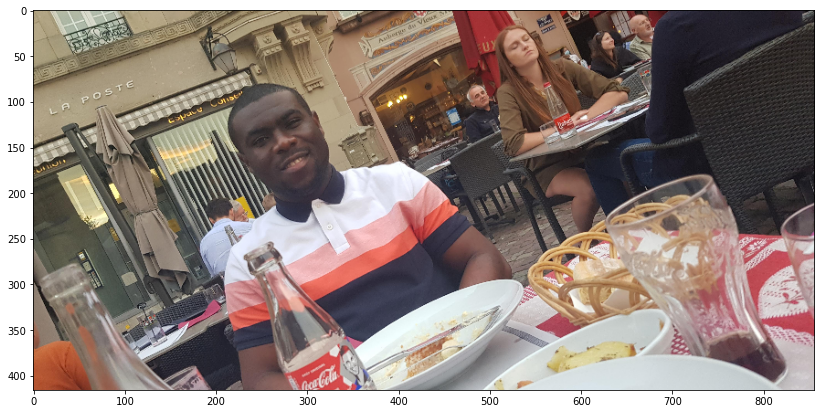

In [16]:
# Plot un-normalized image
plt.imshow(unnorm_image)
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()

## 3) Détection d'objets

In [17]:
def detect(network, array):
    """
    Renvoie les boîtes de délimitation et les prédictions de classe d'un réseau 
        et d'une image donnés.

    @parameters
        network: modèle pré-entraîné de détection d'objets.
            Il est de type mx.gluon.Block
        array : un batch d'images transformées de taille NCHW(1, 3, 416, 416).
            Il est de type mx.nd.NDArray

    @return
        Un tuple de ID de classes, des scores et des boîtes de délimitation 
            des prédictions.
            Ce tuple  est de type mx.nd.NDArrays
    """

    predictions = network(array)

    class_ids, scores, bounding_boxes = predictions

    return class_ids, scores, bounding_boxes

In [20]:
# Predict object detection
class_ids, scores, bounding_boxes = detect(network=network, array=norm_image)

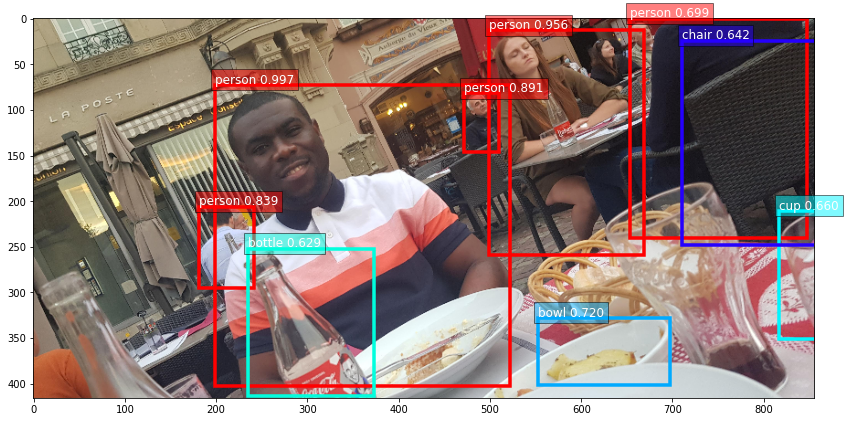

In [21]:
# Plot object detection
ax = utils.viz.plot_bbox(unnorm_image, \
                         bounding_boxes[0], \
                         scores[0], \
                         class_ids[0], \
                         class_names=network.classes)
fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.show()